In [ ]:
Individual evaluation report can be found in Model_Evaluation folder where each SLM
was evaluated with same set of prompts across 2 different similarity search algorithms
1. L2 (default for ChromaDB search) using k = 5 
2. Inner Product using similarity threshold of 0.5

The SLM response was manually evaluated using human evaluation via SQL queries on backend MySQL table. 
The prompts were converted to native MySQL queries and results were compared with SLM response. 
For accuracy score below a weighted model is used since it was determined that 'partially correct'
summaries was due to faults in similarity search model. Therefore the goal of this project is to
enhance the similarity searches and provide more targetted context to SLM for summary generation


Mistral 7B weighted score: 5.5
Gemma 2B weighted score: 3.0


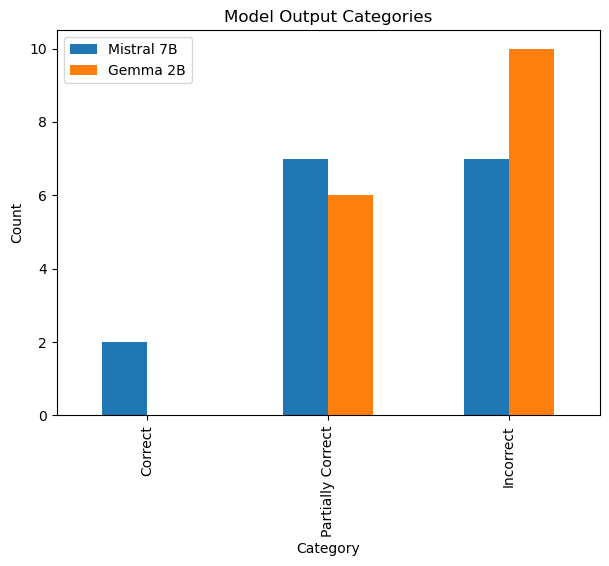

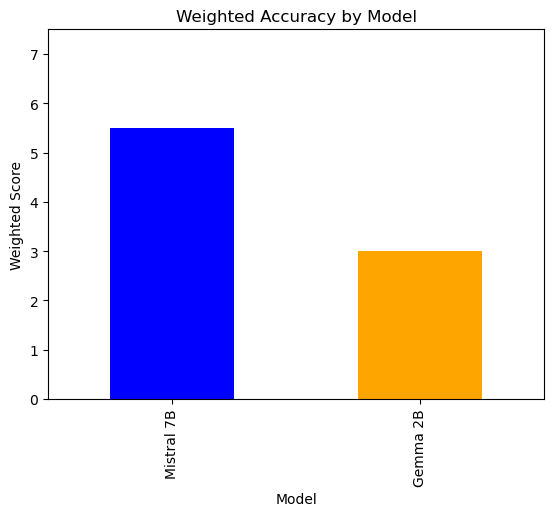

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

categories = ['Correct', 'Partially Correct', 'Incorrect']
mistral_7b = [2, 7, 7]
gemma_2b = [0, 6, 10]

df = pd.DataFrame({
    'Category': categories,
    'Mistral 7B': mistral_7b,
    'Gemma 2B': gemma_2b
})
weights = [1, 0.5, 0]  # Correct=1, Partially Correct=0.5, Incorrect=0

df['Mistral Weighted'] = df['Mistral 7B'] * weights
df['Gemma Weighted'] = df['Gemma 2B'] * weights

mistral_score = df['Mistral Weighted'].sum()
gemma_score = df['Gemma Weighted'].sum()

print(f'Mistral 7B weighted score: {mistral_score}')
print(f'Gemma 2B weighted score: {gemma_score}')
df_plot = df.set_index('Category')[['Mistral 7B', 'Gemma 2B']]
df_plot.plot(kind='bar', figsize=(7,5), ylabel='Count', title='Model Output Categories')
plt.show()
acc_df = pd.DataFrame({
    'Model': ['Mistral 7B', 'Gemma 2B'],
    'Weighted Accuracy': [mistral_score, gemma_score]
})

acc_df.plot(x='Model', y='Weighted Accuracy', kind='bar', legend=False, color=['blue', 'orange'],
            title='Weighted Accuracy by Model', ylabel='Weighted Score')
plt.ylim(0, max(mistral_score, gemma_score) + 2)
plt.show()


L2 Similarity Weighted Score: 5.5
Inner Product Weighted Score: 5.5


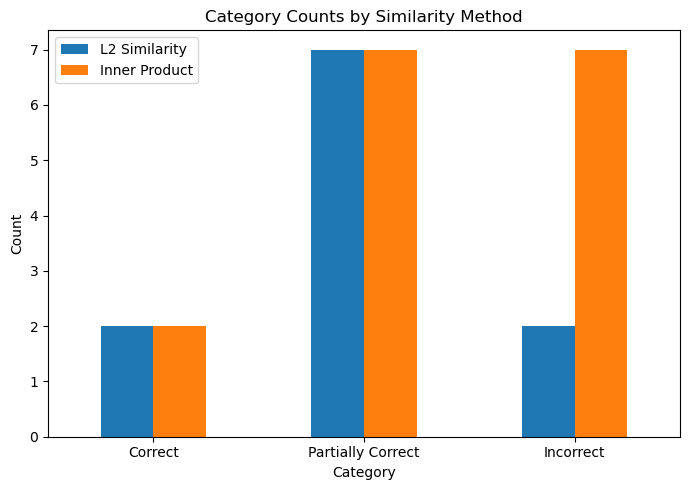

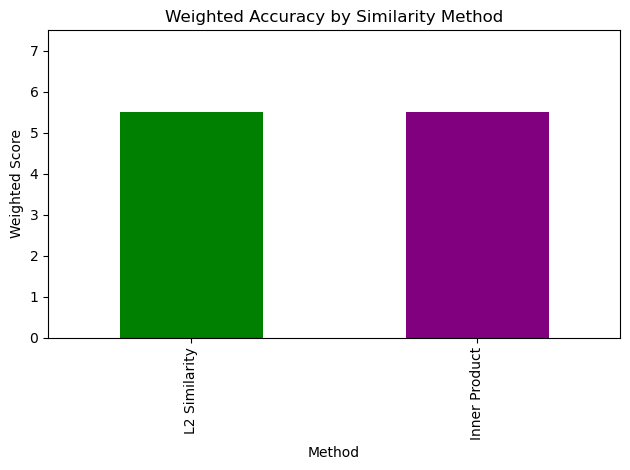

In [2]:
# Data
categories = ['Correct', 'Partially Correct', 'Incorrect']
l2_similarity_search = [2, 7, 2]
inner_product = [2, 7, 7]

# Create DataFrame
df = pd.DataFrame({
    'Category': categories,
    'L2 Similarity': l2_similarity_search,
    'Inner Product': inner_product
})

# Define weights: Correct=1, Partially Correct=0.5, Incorrect=0
weights = [1, 0.5, 0]

# Weighted calculations
df['L2 Weighted'] = df['L2 Similarity'] * weights
df['IP Weighted'] = df['Inner Product'] * weights

# Final weighted scores
l2_score = df['L2 Weighted'].sum()
ip_score = df['IP Weighted'].sum()

print(f"L2 Similarity Weighted Score: {l2_score}")
print(f"Inner Product Weighted Score: {ip_score}")

# Plot raw category counts
df_plot = df.set_index('Category')[['L2 Similarity', 'Inner Product']]
df_plot.plot(kind='bar', figsize=(7,5), title='Category Counts by Similarity Method', ylabel='Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
acc_df = pd.DataFrame({
    'Method': ['L2 Similarity', 'Inner Product'],
    'Weighted Accuracy': [l2_score, ip_score]
})

acc_df.plot(x='Method', y='Weighted Accuracy', kind='bar', legend=False, color=['green', 'purple'],
            title='Weighted Accuracy by Similarity Method', ylabel='Weighted Score')
plt.ylim(0, max(l2_score, ip_score) + 2)
plt.tight_layout()
plt.show()


Inner product was chosen as choice of algorithm for RAG model since it encompasses more relevant context and is not restrictive to a discrete size of K as in nearest neighbours. 
To enhance context retrieval - all-MiniLM-L6-v2 was fine tuned on application summary data. In addition a regex score was added to inner product similarity threshold selection block. This enhancement gave more weight to context that specifically matched patient name or mrn given in user prompt. 

In [ ]:
#Fine tuned all-MininLM-L6-v2 results.
17%|█▋        | 8/48 [00:50<03:42,  5.57s/it]{'eval_val_pearson_cosine': 0.8168691685758459, 'eval_val_spearman_cosine': 0.6221504176814271, 'eval_runtime': 3.7279, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 0.5}
  33%|███▎      | 16/48 [01:46<03:18,  6.20s/it]{'eval_val_pearson_cosine': 0.8527565956989378, 'eval_val_spearman_cosine': 0.620982060089537, 'eval_runtime': 5.6059, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 1.0}
  50%|█████     | 24/48 [04:23<09:03, 22.64s/it]{'eval_val_pearson_cosine': 0.870146415446412, 'eval_val_spearman_cosine': 0.6221504176814271, 'eval_runtime': 10.8731, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 1.5}
  67%|██████▋   | 32/48 [07:04<03:01, 11.32s/it]{'eval_val_pearson_cosine': 0.8790783403156512, 'eval_val_spearman_cosine': 0.626823848048987, 'eval_runtime': 7.6208, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 2.0}
  83%|████████▎ | 40/48 [08:22<01:09,  8.63s/it]{'eval_val_pearson_cosine': 0.8821762144555576, 'eval_val_spearman_cosine': 0.6303289208246572, 'eval_runtime': 4.7064, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 2.5}
 100%|██████████| 48/48 [09:40<00:00,  8.16s/it]{'eval_val_pearson_cosine': 0.8828440573817351, 'eval_val_spearman_cosine': 0.6303289208246572, 'eval_runtime': 4.7177, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 3.0}
 {'train_runtime': 584.966, 'train_samples_per_second': 2.6, 'train_steps_per_second': 0.082, 'train_loss': 0.08357433478037517, 'epoch': 3.0}
 100%|██████████| 48/48 [09:44<00:00, 12.19s/it]
 Training finished. Best model saved in: finetuned-all-MiniLM-L6-v2

In conjunction to fine tuning the transformer - there was also more targetted prompt engineering measures taken for next evaluation. 

Finetuned Targeted Prompts score: 8.5
Default Inner Product score: 5.5


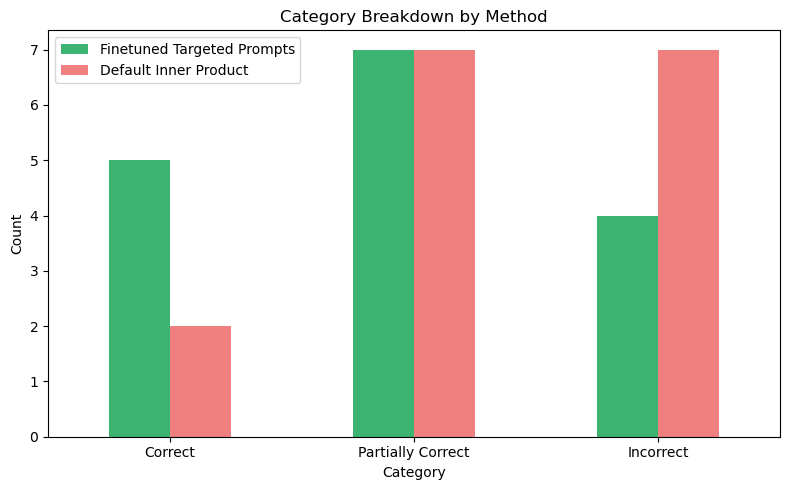

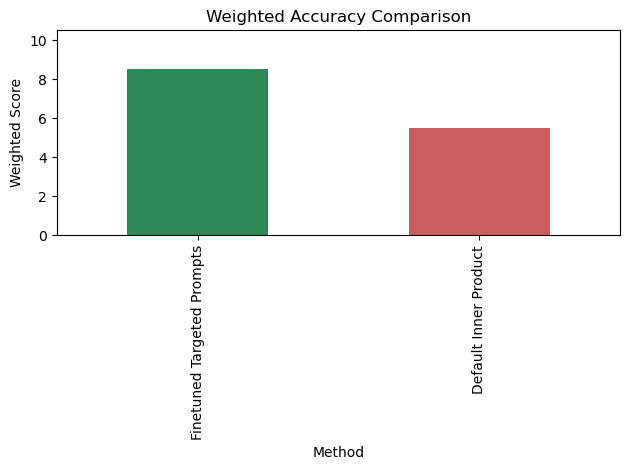

In [5]:
# Input data
categories = ['Correct', 'Partially Correct', 'Incorrect']
finetuned = [5, 7, 4]
default_ip = [2, 7, 7]
weights = [1.0, 0.5, 0.0]

# Create DataFrame
df = pd.DataFrame({
    'Category': categories,
    'Finetuned Targeted Prompts': finetuned,
    'Default Inner Product': default_ip
})

# Calculate weighted score for each method
df['Finetuned Weighted'] = df['Finetuned Targeted Prompts'] * weights
df['Default IP Weighted'] = df['Default Inner Product'] * weights

# Total weighted scores
finetuned_score = df['Finetuned Weighted'].sum()
default_ip_score = df['Default IP Weighted'].sum()

print(f"Finetuned Targeted Prompts score: {finetuned_score}")
print(f"Default Inner Product score: {default_ip_score}")
# Plot category-wise counts
df_plot = df.set_index('Category')[['Finetuned Targeted Prompts', 'Default Inner Product']]
df_plot.plot(kind='bar', figsize=(8, 5), title='Category Breakdown by Method',
             ylabel='Count', color=['mediumseagreen', 'lightcoral'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
# Create DataFrame for weighted accuracy comparison
score_df = pd.DataFrame({
    'Method': ['Finetuned Targeted Prompts', 'Default Inner Product'],
    'Weighted Accuracy': [finetuned_score, default_ip_score]
})

# Plot weighted accuracy
score_df.plot(x='Method', y='Weighted Accuracy', kind='bar',
             title='Weighted Accuracy Comparison',
             ylabel='Weighted Score', legend=False,
             color=['seagreen', 'indianred'])
plt.ylim(0, max(finetuned_score, default_ip_score) + 2)
plt.tight_layout()
plt.show()


Accuracy was significantly improved by adding more parameters in prompt and fine tuning sentence 
transformer according to application data. However there is room for improvements. As next steps 
I'd like to add weighted encoding to text .It was noticed that the context was targetted and most appropriate for the parameters that occur in majority in dataset which made indexing biased. To remove this majority bias I would build a strategy that enables targetting indexing with important parameters in prompt like patient_name and patient_mrn so that underrepresentation is not a hindrance in selection.
                                        